# Phishing Email Detector

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)

# XGBoost
import xgboost as xgb

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# For text tokenization
from collections import Counter
import re

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Styling
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

DATA_PATH = Path("data/preprocessed/emails_combined.csv")
#DATA_PATH_POISONED = Path("data/preprocessed/emails_combined_poisoned.csv")
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

# Feature columns for ML models
FEATURE_COLS = [
    "num_words",
    "num_unique_words",
    "num_stopwords",
    "num_links",
    "num_unique_domains",
    "num_email_addresses",
    "num_spelling_errors",
    "num_urgent_keywords",
]

# Deep Learning parameters
MAX_VOCAB_SIZE = 10000  # Vocabulary size
MAX_LEN = 200  # Maximum sequence length
EMBEDDING_DIM = 128  # Embedding dimension
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Email Class

In [2]:
class EmailDataset(Dataset):
    """PyTorch Dataset for email classification."""

    def __init__(self, texts, features, labels, vocab=None, max_len=MAX_LEN):
        self.texts = texts
        self.features = features
        self.labels = labels
        self.max_len = max_len

        # Build or use existing vocabulary
        if vocab is None:
            self.vocab = self.build_vocab(texts)
        else:
            self.vocab = vocab

    def build_vocab(self, texts):
        """Build vocabulary from texts."""
        word_counts = Counter()
        for text in texts:
            words = self.tokenize(text)
            word_counts.update(words)

        # Get most common words
        most_common = word_counts.most_common(
            MAX_VOCAB_SIZE - 2
        )  # Reserve for PAD and UNK

        # Build vocab dictionary
        vocab = {"<PAD>": 0, "<UNK>": 1}
        for idx, (word, _) in enumerate(most_common, start=2):
            vocab[word] = idx

        return vocab

    def tokenize(self, text):
        """Simple tokenization."""
        text = text.lower()
        words = re.findall(r"\b\w+\b", text)
        return words

    def text_to_sequence(self, text):
        """Convert text to sequence of indices."""
        words = self.tokenize(text)
        sequence = [self.vocab.get(word, self.vocab["<UNK>"]) for word in words]

        # Truncate or pad
        if len(sequence) > self.max_len:
            sequence = sequence[: self.max_len]
        else:
            sequence = sequence + [self.vocab["<PAD>"]] * (self.max_len - len(sequence))

        return sequence

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        features = self.features.iloc[idx]
        label = self.labels.iloc[idx]

        sequence = self.text_to_sequence(text)

        return (
            torch.tensor(sequence, dtype=torch.long),
            torch.tensor(features.values, dtype=torch.float32),
            torch.tensor(label, dtype=torch.float32),
        )

## Models

In [3]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name, to_plot=True, to_save_plots=False):
    """Evaluate model performance, print metrics, and optionally plot results."""

    print(f"\n📊 Evaluation Metrics for {model_name}:")
    print("-" * 70)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0) # Added zero_division
    recall = recall_score(y_true, y_pred, zero_division=0)    # Added zero_division
    f1 = f1_score(y_true, y_pred, zero_division=0)          # Added zero_division
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    # Confusion matrix
    print(f"\n📊 Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    # Classification report
    print(f"\n📋 Classification Report:")
    print(
        classification_report(y_true, y_pred, target_names=["Legitimate", "Phishing"], zero_division=0)
    )

    # --- New Plotting Section ---
    if to_plot:
        print("\n📈 Generating plots...")
        
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
        
        # 1. Plot Confusion Matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                    xticklabels=['Legitimate', 'Phishing'],
                    yticklabels=['Legitimate', 'Phishing'])
        ax1.set_title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Actual Label', fontsize=12)
        ax1.set_xlabel('Predicted Label', fontsize=12)

        # 2. Plot ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
        ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('False Positive Rate', fontsize=12)
        ax2.set_ylabel('True Positive Rate', fontsize=12)
        ax2.set_title(f'ROC Curve - {model_name}', fontsize=14, fontweight='bold')
        ax2.legend(loc="lower right", fontsize=10)
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        
        if to_save_plots:
            # Save the figure
            safe_model_name = model_name.replace(' ', '_').lower()
            plot_filename = RESULTS_DIR / f'{safe_model_name}_evaluation.png'
            try:
                plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
                print(f"   ✓ Saved evaluation plots to: {plot_filename}")
            except Exception as e:
                print(f"   ⚠️ Could not save plots: {e}")
        
        plt.show() # Uncomment this if running in an interactive notebook
        plt.close(fig) # Close the figure to free up memory

    # --- End Plotting Section ---

    # Store results
    results = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba,
    }

    return results

### DL and ML Models

#### DL

In [4]:
class LSTMClassifier(nn.Module):
    """LSTM model for text classification."""

    def __init__(
        self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.5
    ):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True,
        )
        self.fc1 = nn.Linear(hidden_dim * 2, 64)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        # LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Use last hidden state (concatenate forward and backward)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)

        # Fully connected layers
        out = self.fc1(hidden)
        out = torch.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)

        return out.squeeze()


class CNNClassifier(nn.Module):
    """CNN model for text classification."""

    def __init__(
        self,
        vocab_size,
        embedding_dim,
        num_filters=128,
        filter_sizes=[3, 4, 5],
        dropout=0.5,
    ):
        super(CNNClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Multiple convolutional layers with different filter sizes
        self.convs = nn.ModuleList(
            [
                nn.Conv1d(
                    in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs
                )
                for fs in filter_sizes
            ]
        )

        self.fc1 = nn.Linear(len(filter_sizes) * num_filters, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        # Permute for Conv1d: (batch_size, embedding_dim, seq_len)
        embedded = embedded.permute(0, 2, 1)

        # Apply convolution and max pooling
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        # Concatenate pooled outputs
        cat = torch.cat(pooled, dim=1)

        # Fully connected layers
        out = self.fc1(cat)
        out = torch.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)

        return out.squeeze()


class TabTransformer(nn.Module):
    """TabTransformer model combining text sequence features with numeric tabular features."""

    def __init__(
        self,
        vocab_size,
        text_embedding_dim,
        num_tabular_features,
        d_model=128,
        nhead=4,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.3,
    ):
        super(TabTransformer, self).__init__()

        # ---- Text Embedding ----
        self.text_embedding = nn.Embedding(
            vocab_size, text_embedding_dim, padding_idx=0
        )

        # Project to transformer dimension
        self.text_projection = nn.Linear(text_embedding_dim, d_model)

        # ---- Tabular Embeddings (each feature → token) ----
        self.num_tabular_features = num_tabular_features
        self.tabular_embeddings = nn.ModuleList(
            [nn.Linear(1, d_model) for _ in range(num_tabular_features)]
        )

        # ---- Positional Encoding ----
        self.positional_encoding = nn.Parameter(
            torch.randn(1, num_tabular_features + 1, d_model)  # +1 for text token
        )

        # ---- Transformer Encoder ----
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )

        # ---- Classification Head ----
        self.fc1 = nn.Linear(d_model * (num_tabular_features + 1), 128)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text_input, tabular_input):
        batch_size = text_input.size(0)

        # ---- Text Token ----
        text_emb = self.text_embedding(text_input)  # (B, seq, emb)
        text_pooled = torch.mean(text_emb, dim=1)  # (B, emb)
        text_token = self.text_projection(text_pooled).unsqueeze(1)

        # ---- Tabular Tokens ----
        tab_tokens = []
        for i in range(self.num_tabular_features):
            f = tabular_input[:, i : i + 1]
            tok = self.tabular_embeddings[i](f).unsqueeze(1)
            tab_tokens.append(tok)

        # ---- Concatenate All Tokens ----
        tokens = torch.cat([text_token] + tab_tokens, dim=1)

        # ---- Add Positional Encoding ----
        tokens = tokens + self.positional_encoding

        # ---- Transformer ----
        x = self.transformer_encoder(tokens)

        # ---- Classification ----
        flat = x.reshape(batch_size, -1)
        out = torch.relu(self.fc1(flat))
        out = self.dropout(out)
        out = torch.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.sigmoid(out)

        return out.squeeze()


def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for sequences, features, labels in dataloader:
        sequences, features, labels = (
            sequences.to(device),
            features.to(device),
            labels.to(device),
        )

        # Forward pass
        optimizer.zero_grad()
        if isinstance(model, TabTransformer):
            outputs = model(sequences, features)
        else:
            outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    """Evaluate model."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for sequences, features, labels in dataloader:
            sequences, features, labels = (
                sequences.to(device),
                features.to(device),
                labels.to(device),
            )

            # Forward pass
            if isinstance(model, TabTransformer):
                outputs = model(sequences, features)
            else:
                outputs = model(sequences)
            loss = criterion(outputs, labels)

            # Statistics
            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Store predictions
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return (
        avg_loss,
        accuracy,
        np.array(all_labels),
        np.array(all_preds),
        np.array(all_probs),
    )


def train_dl_models(
    X_features_train,
    X_features_test,
    X_text_train,
    X_text_test,
    y_labels_train,
    y_labels_test,
    to_plot=True,
    to_save_plots=False,
):
    """Train and evaluate deep learning models using PyTorch: LSTM and CNN."""

    from sklearn.preprocessing import StandardScaler

    # Scale features
    scaler = StandardScaler()

    X_features_train = pd.DataFrame(
        scaler.fit_transform(X_features_train), columns=X_features_train.columns
    )
    X_features_test = pd.DataFrame(
        scaler.transform(X_features_test), columns=X_features_test.columns
    )

    # Create datasets
    print("Preparing datasets...")
    train_dataset = EmailDataset(
        X_text_train.reset_index(drop=True),
        X_features_train.reset_index(drop=True),
        y_labels_train.reset_index(drop=True),
    )
    test_dataset = EmailDataset(
        X_text_test.reset_index(drop=True),
        X_features_test.reset_index(drop=True),
        y_labels_test.reset_index(drop=True),
        vocab=train_dataset.vocab,
    )

    # Create validation split from training data
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"✅ Vocabulary size: {len(test_dataset.vocab)}")
    print(f"✅ Train samples: {len(train_dataset)}")
    print(f"✅ Validation samples: {len(val_dataset)}")
    print(f"✅ Test samples: {len(test_dataset)}")

    # Dictionary to store results
    dl_results = {}

    # Loss function
    criterion = nn.BCELoss()

    # ========================================================================
    # 1. LSTM Model
    # ========================================================================
    print("\n" + "=" * 70)
    print("1. LSTM MODEL")
    print("=" * 70)

    lstm_model = LSTMClassifier(
        vocab_size=len(test_dataset.vocab),
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=64,
        num_layers=2,
        dropout=0.5,
    ).to(device)

    print(f"Model architecture:")
    print(lstm_model)

    optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

    print(f"Training LSTM for {EPOCHS} epochs...")
    best_val_loss = float("inf")
    patience = 3
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(
            lstm_model, train_loader, criterion, optimizer, device
        )
        val_loss, val_acc, _, _, _ = evaluate(lstm_model, val_loader, criterion, device)

        print(
            f"Epoch {epoch+1}/{EPOCHS} - "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(lstm_model.state_dict(), RESULTS_DIR / "best_lstm.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model
    lstm_model.load_state_dict(torch.load(RESULTS_DIR / "best_lstm.pth"))

    print("\n✅ Training complete!")

    # Evaluate on test set
    _, _, y_true_lstm, y_pred_lstm, y_prob_lstm = evaluate(
        lstm_model, test_loader, criterion, device
    )

    dl_results["LSTM"] = evaluate_model(
        y_true_lstm,
        y_pred_lstm,
        y_prob_lstm,
        "LSTM",
        to_plot=to_plot,
        to_save_plots=to_save_plots,
    )

    # ========================================================================
    # 2. CNN Model
    # ========================================================================
    print("\n" + "=" * 70)
    print("2. CNN MODEL")
    print("=" * 70)

    cnn_model = CNNClassifier(
        vocab_size=len(test_dataset.vocab),
        embedding_dim=EMBEDDING_DIM,
        num_filters=128,
        filter_sizes=[3, 4, 5],
        dropout=0.5,
    ).to(device)

    print(f"Model architecture:")
    print(cnn_model)

    optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

    print(f"Training CNN for {EPOCHS} epochs...")
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(
            cnn_model, train_loader, criterion, optimizer, device
        )
        val_loss, val_acc, _, _, _ = evaluate(cnn_model, val_loader, criterion, device)

        print(
            f"Epoch {epoch+1}/{EPOCHS} - "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(cnn_model.state_dict(), RESULTS_DIR / "best_cnn.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model
    cnn_model.load_state_dict(torch.load(RESULTS_DIR / "best_cnn.pth"))

    print("\n✅ Training complete!")
    print("\n📊 Evaluating on test set...")

    # Evaluate on test set
    _, _, y_true_cnn, y_pred_cnn, y_prob_cnn = evaluate(
        cnn_model, test_loader, criterion, device
    )

    dl_results["CNN"] = evaluate_model(
        y_true_cnn,
        y_pred_cnn,
        y_prob_cnn,
        "CNN",
        to_plot=to_plot,
        to_save_plots=to_save_plots,
    )

    # ========================================================================
    # 3. TabTransformer Model
    # ========================================================================
    print("\n" + "=" * 70)
    print("3. TABTRANSFORMER MODEL")
    print("=" * 70)

    tabtransformer_model = TabTransformer(
        vocab_size=len(test_dataset.vocab),
        text_embedding_dim=EMBEDDING_DIM,
        num_tabular_features=X_features_train.shape[1],
    ).to(device)

    print(f"Model architecture:")
    print(tabtransformer_model)

    optimizer = optim.Adam(tabtransformer_model.parameters(), lr=LEARNING_RATE)

    print(f"Training TabTransformer for {EPOCHS} epochs...")
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(
            tabtransformer_model, train_loader, criterion, optimizer, device
        )
        val_loss, val_acc, _, _, _ = evaluate(
            tabtransformer_model, val_loader, criterion, device
        )

        print(
            f"Epoch {epoch+1}/{EPOCHS} - "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(
                tabtransformer_model.state_dict(),
                RESULTS_DIR / "best_tabtransformer.pth",
            )
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model
    tabtransformer_model.load_state_dict(
        torch.load(RESULTS_DIR / "best_tabtransformer.pth")
    )

    print("\n✅ Training complete!")
    print("\n📊 Evaluating on test set...")

    # Evaluate on test set
    _, _, y_true_tabtransformer, y_pred_tabtransformer, y_prob_tabtransformer = (
        evaluate(tabtransformer_model, test_loader, criterion, device)
    )

    dl_results["TabTransformer"] = evaluate_model(
        y_true_tabtransformer,
        y_pred_tabtransformer,
        y_prob_tabtransformer,
        "TabTransformer",
        to_plot=to_plot,
        to_save_plots=to_save_plots,
    )

    print("\n" + "=" * 70 + "\n")

    return dl_results, (lstm_model, cnn_model, tabtransformer_model)

##### ML

In [5]:
def train_ml_models(X_features_train, X_features_test, y_labels_train, y_labels_test, to_plot=False, to_save_plots=False):
    """Train and evaluate ML models: Logistic Regression, Random Forest, XGBoost."""

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_features_train)
    X_test_scaled = scaler.transform(X_features_test)

    # Dictionary to store results
    ml_results = {}

    # ========================================================================
    # 1. Logistic Regression
    # ========================================================================
    print("\n" + "=" * 70)
    print("1. LOGISTIC REGRESSION")
    print("=" * 70)

    print("Training Logistic Regression...")
    lr_model = LogisticRegression(max_iter=1000, random_state=SEED)
    lr_model.fit(X_train_scaled, y_labels_train)

    print("✅ Training complete!")

    # Predictions
    y_pred_lr = lr_model.predict(X_test_scaled)
    y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate
    ml_results["Logistic Regression"] = evaluate_model(
        y_labels_test, y_pred_lr, y_pred_proba_lr, "Logistic Regression", to_plot=to_plot, to_save_plots=to_save_plots
    )

    # ========================================================================
    # 2. Random Forest
    # ========================================================================
    print("\n" + "=" * 70)
    print("2. RANDOM FOREST")
    print("=" * 70)

    print("Training Random Forest...")
    rf_model = RandomForestClassifier(
        n_estimators=100, max_depth=20, random_state=SEED, n_jobs=-1
    )
    rf_model.fit(X_features_train, y_labels_train)

    print("✅ Training complete!")

    # Predictions
    y_pred_rf = rf_model.predict(X_features_test)
    y_pred_proba_rf = rf_model.predict_proba(X_features_test)[:, 1]

    # Evaluate
    ml_results["Random Forest"] = evaluate_model(
        y_labels_test, y_pred_rf, y_pred_proba_rf, "Random Forest", to_plot=to_plot, to_save_plots=to_save_plots
    )

    # Feature importance
    print("Feature Importance (Random Forest):")
    feature_importance = pd.DataFrame(
        {"feature": FEATURE_COLS, "importance": rf_model.feature_importances_}
    ).sort_values("importance", ascending=False)
    print(feature_importance)

    # ========================================================================
    # 3. XGBoost
    # ========================================================================
    print("\n" + "=" * 70)
    print("3. XGBOOST")
    print("=" * 70)

    print("Training XGBoost...")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric="logloss",
    )
    xgb_model.fit(X_features_train, y_labels_train)

    print("✅ Training complete!")

    # Predictions
    y_pred_xgb = xgb_model.predict(X_features_test)
    y_pred_proba_xgb = xgb_model.predict_proba(X_features_test)[:, 1]

    # Evaluate
    ml_results["XGBoost"] = evaluate_model(
        y_labels_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost", to_plot=to_plot, to_save_plots=to_save_plots
    )

    # Feature importance
    print("Feature Importance (XGBoost):")
    feature_importance_xgb = pd.DataFrame(
        {"feature": FEATURE_COLS, "importance": xgb_model.feature_importances_}
    ).sort_values("importance", ascending=False)
    print(feature_importance_xgb)

    print("\n" + "=" * 70 + "\n")

    return ml_results, (lr_model, rf_model, xgb_model)

## Training

In [6]:
def load_and_split_data(test_size=0.2, random_state=42):
    """Load the preprocessed data and split into train/test sets."""

    # Load data
    print(f"Loading data from: {DATA_PATH}")
    df = pd.read_csv(DATA_PATH)

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Check for missing values
    print(f"\nMissing values:")
    print(df.isnull().sum())

    # Class distribution
    print(f"\nClass distribution:")
    print(df["label"].value_counts())
    print(f"Class balance:")
    print(df["label"].value_counts(normalize=True))

    # Split indexes only once using stratification
    print(f"\nSplitting data (test_size={test_size})...")

    train_idx, test_idx = train_test_split(
        df.index, test_size=test_size, random_state=random_state, stratify=df["label"]
    )

    # Slice everything consistently
    X_features_train = df.loc[train_idx, FEATURE_COLS]
    X_features_test = df.loc[test_idx, FEATURE_COLS]

    X_text_train = df.loc[train_idx, "text"]
    X_text_test = df.loc[test_idx, "text"]

    y_label_train = df.loc[train_idx, "label"]
    y_label_test = df.loc[test_idx, "label"]

    print(f"✅ Train set: {len(train_idx)} samples")
    print(f"✅ Test set: {len(test_idx)} samples")

    return X_features_train, X_features_test, X_text_train, X_text_test, y_label_train, y_label_test

In [7]:
# Load dataset
X_features_train, X_features_test, X_text_train, X_text_test, y_label_train, y_label_test = load_and_split_data(
    test_size=0.2, random_state=SEED
)

Loading data from: data/preprocessed/emails_combined.csv
Dataset shape: (28341, 10)
Columns: ['text', 'label', 'num_words', 'num_unique_words', 'num_stopwords', 'num_links', 'num_unique_domains', 'num_email_addresses', 'num_spelling_errors', 'num_urgent_keywords']

Missing values:
text                   0
label                  0
num_words              0
num_unique_words       0
num_stopwords          0
num_links              0
num_unique_domains     0
num_email_addresses    0
num_spelling_errors    0
num_urgent_keywords    0
dtype: int64

Class distribution:
label
0    21203
1     7138
Name: count, dtype: int64
Class balance:
label
0    0.748139
1    0.251861
Name: proportion, dtype: float64

Splitting data (test_size=0.2)...
✅ Train set: 22672 samples
✅ Test set: 5669 samples


In [8]:
# Train ML models and get their results and the trained model objects
ml_results, (lr_model, rf_model, xgb_model) = train_ml_models(
    X_features_train, X_features_test, y_label_train, y_label_test, to_plot=False, to_save_plots=False
)


1. LOGISTIC REGRESSION
Training Logistic Regression...
✅ Training complete!

📊 Evaluation Metrics for Logistic Regression:
----------------------------------------------------------------------
Accuracy:  0.7495
Precision: 0.5351
Recall:    0.0427
F1-Score:  0.0791
ROC-AUC:   0.6705

📊 Confusion Matrix:
[[4188   53]
 [1367   61]]

📋 Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.75      0.99      0.86      4241
    Phishing       0.54      0.04      0.08      1428

    accuracy                           0.75      5669
   macro avg       0.64      0.52      0.47      5669
weighted avg       0.70      0.75      0.66      5669


2. RANDOM FOREST
Training Random Forest...
✅ Training complete!

📊 Evaluation Metrics for Random Forest:
----------------------------------------------------------------------
Accuracy:  0.8289
Precision: 0.7313
Recall:    0.5070
F1-Score:  0.5988
ROC-AUC:   0.8499

📊 Confusion Matrix:
[[3975  266]
 [ 704  724]]

In [9]:
# Train DL models and get their results and the trained model objects
dl_results, (lstm_model, cnn_model, tabtransformer_model) = train_dl_models(
    X_features_train, X_features_test, X_text_train, X_text_test, y_label_train, y_label_test, to_plot=False, to_save_plots=False
)

Preparing datasets...
✅ Vocabulary size: 10000
✅ Train samples: 18137
✅ Validation samples: 4535
✅ Test samples: 5669

1. LSTM MODEL
Model architecture:
LSTMClassifier(
  (embedding): Embedding(10000, 128, padding_idx=0)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Training LSTM for 10 epochs...
Epoch 1/10 - Train Loss: 0.2697, Train Acc: 0.8854 | Val Loss: 0.1558, Val Acc: 0.9416
Epoch 2/10 - Train Loss: 0.1373, Train Acc: 0.9512 | Val Loss: 0.1752, Val Acc: 0.9383
Epoch 3/10 - Train Loss: 0.0783, Train Acc: 0.9724 | Val Loss: 0.1039, Val Acc: 0.9643
Epoch 4/10 - Train Loss: 0.0530, Train Acc: 0.9827 | Val Loss: 0.1100, Val Acc: 0.9616
Epoch 5/10 - Train Loss: 0.0331, Train Acc: 0.9880 | Val Loss: 0.1932, Val Acc: 0.9550
Epoch 6/10 - Train Loss: 0.0312, Tra

In [10]:
def compare_all_models(ml_results, dl_results, save_csv=True, save_plots=True):
    """Compare all models and visualize results."""

    # Combine results
    all_results = {**ml_results, **dl_results}

    # Create comparison dataframe
    comparison_df = pd.DataFrame(
        {
            "Model": list(all_results.keys()),
            "Accuracy": [r["accuracy"] for r in all_results.values()],
            "Precision": [r["precision"] for r in all_results.values()],
            "Recall": [r["recall"] for r in all_results.values()],
            "F1-Score": [r["f1"] for r in all_results.values()],
            "ROC-AUC": [r["roc_auc"] for r in all_results.values()],
        }
    )

    # Add approach column
    comparison_df["Approach"] = comparison_df["Model"].apply(
        lambda x: "ML" if x in ml_results else "DL"
    )

    print("Model Comparison:")
    print("=" * 70)
    print(comparison_df.to_string(index=False))

    # Save to CSV
    if save_csv:
        comparison_df.to_csv(RESULTS_DIR / "model_comparison.csv", index=False)
        print(f"Saved comparison to: {RESULTS_DIR / 'model_comparison.csv'}")

    # Visualizations
    print("Creating visualizations...")
    create_visualizations(comparison_df, all_results, save_plots=save_plots)

    return comparison_df


def create_visualizations(comparison_df, all_results, save_plots=True):
    """Create comparison visualizations."""

    # 1. Metrics comparison bar plot
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle("ML vs DL Model Comparison", fontsize=16, fontweight="bold")

    metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 3, idx % 3]
        ax = axes[idx // 3, idx % 3]
        colors = [
            "skyblue" if a == "ML" else "lightcoral" for a in comparison_df["Approach"]
        ]
        bars = ax.bar(comparison_df["Model"], comparison_df[metric], color=colors)
        ax.set_title(metric, fontsize=14, fontweight="bold")
        ax.set_ylabel("Score", fontsize=12)
        ax.set_ylim([0, 1.0])
        ax.grid(axis="y", alpha=0.3)
        ax.tick_params(axis="x", rotation=45)
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{height:.3f}",
                ha="center",
                va="bottom",
                fontsize=10,
            )

    # Legend in the last subplot
    axes[1, 2].axis("off")
    axes[1, 2].legend(
        handles=[
            plt.Rectangle((0, 0), 1, 1, fc="skyblue", label="ML Approach"),
            plt.Rectangle((0, 0), 1, 1, fc="lightcoral", label="DL Approach"),
        ],
        loc="center",
        fontsize=12,
    )
    plt.tight_layout()

    if save_plots:
        plt.savefig(
            RESULTS_DIR / "metrics_comparison.png", dpi=300, bbox_inches="tight"
        )
        print(f" ✓ Saved: {RESULTS_DIR / 'metrics_comparison.png'}")

    plt.show()

    plt.close()

    # 2. ROC Curves comparison
    fig, ax = plt.subplots(figsize=(8, 6))
    cmap = plt.get_cmap("tab10")
    num_models = len(all_results)
    for idx, (model_name, results) in enumerate(all_results.items()):
        # try/except for cases where roc cannot be computed
        try:
            fpr, tpr, _ = roc_curve(results["y_true"], results["y_pred_proba"])
            auc = results["roc_auc"]
            ax.plot(
                fpr,
                tpr,
                label=f"{model_name} (AUC = {auc:.3f})",
                linewidth=2,
                color=cmap(idx % 10),
            )
        except Exception:
            print(f"Could not plot ROC for {model_name}")
    ax.plot([0, 1], [0, 1], "k--", linewidth=2, label="Random Classifier")
    ax.set_xlabel("False Positive Rate", fontsize=12)
    ax.set_ylabel("True Positive Rate", fontsize=12)
    ax.set_title("ROC Curves - All Models", fontsize=14, fontweight="bold")
    ax.legend(loc="lower right", fontsize=10)

    if save_plots:
        plt.savefig(
            RESULTS_DIR / "roc_curves_all_models.png", dpi=300, bbox_inches="tight"
        )
        print(f" ✓ Saved: {RESULTS_DIR / 'roc_curves_all_models.png'}")

    plt.show()

    plt.close()

Model Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC Approach
Logistic Regression  0.749515   0.535088 0.042717  0.079118 0.670496       ML
      Random Forest  0.828894   0.731313 0.507003  0.598842 0.849852       ML
            XGBoost  0.799788   0.692510 0.369048  0.481498 0.823946       ML
               LSTM  0.965779   0.932073 0.932073  0.932073 0.991765       DL
                CNN  0.968778   0.921212 0.957983  0.939238 0.994056       DL
     TabTransformer  0.971600   0.940849 0.946779  0.943805 0.993281       DL
Saved comparison to: results/model_comparison.csv
Creating visualizations...
 ✓ Saved: results/metrics_comparison.png


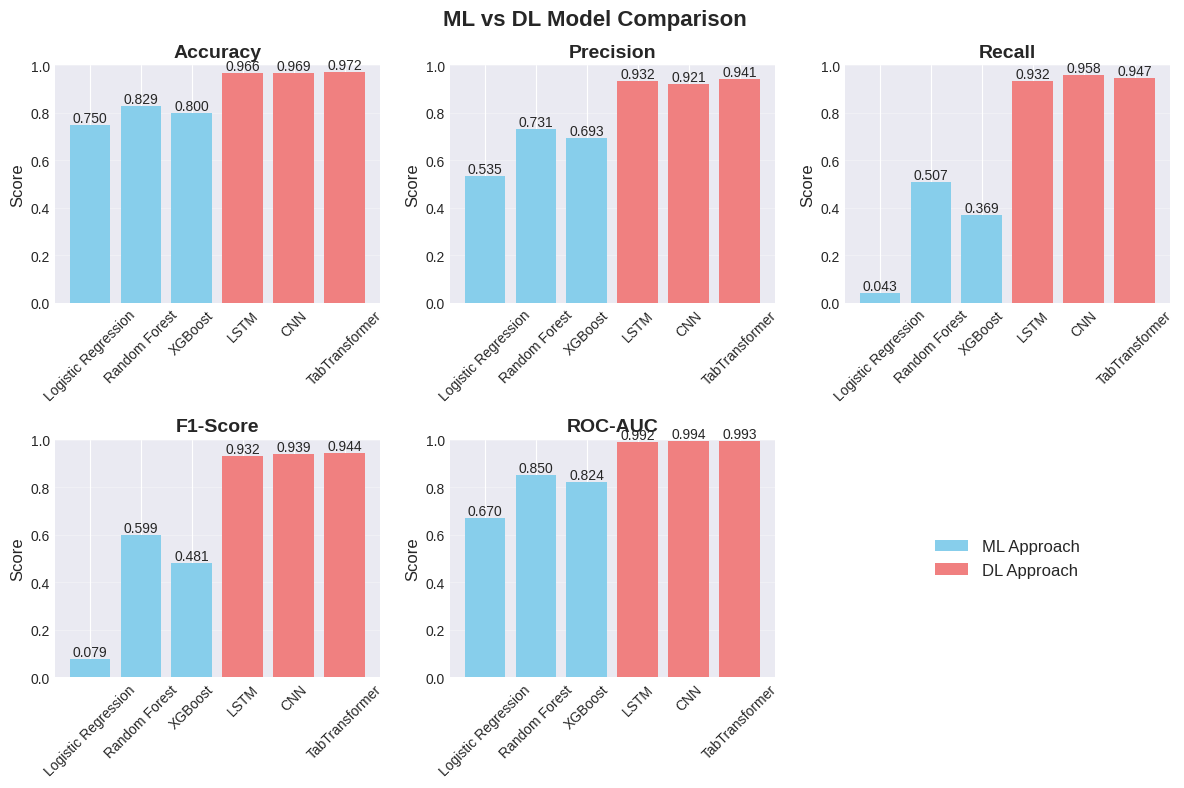

 ✓ Saved: results/roc_curves_all_models.png


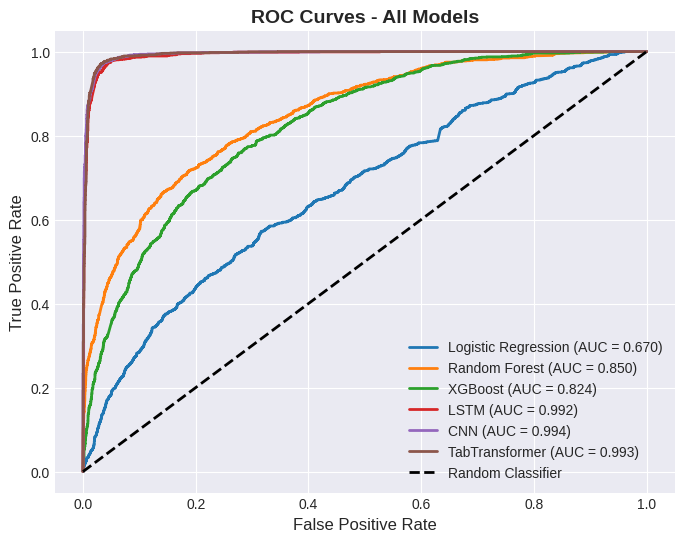

In [11]:
# Compare all results and generate final reports and visualizations
comparison_df = compare_all_models(ml_results, dl_results, save_csv=True, save_plots=True)